# Detection with DIGITS

In this example we'll try to detect buildings in an aerial image.

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
from PIL import ImageDraw
from skimage.feature import  blob_log
# Make sure that caffe is on the python path:
caffe_root = '/home/agray/Documents/dltools/nvcaffe_v15/' 
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

TEST_IMAGES_PATH='../imgs/'
TESTIMAGE=TEST_IMAGES_PATH+'001052.png'
LABELFILE=TEST_IMAGES_PATH+'001052.txt'

In [2]:
caffe.set_mode_cpu()
#caffe.set_device(0)
#caffe.set_mode_gpu()
net = caffe.Net('../model/deploy.prototxt',
                '../model/snapshot_iter_142080.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.array([ 72.10082436,  93.99016094,  87.88383961]))# mean pixel
transformer.set_mean('data', np.load('model/mean.npy'))# mean image
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [3]:
# set net to batch size of 1
net.blobs['data'].reshape(1,3,1280,1280)

Feed in the image (with some preprocessing) and classify with a forward pass.

In [7]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(TESTIMAGE))
net.forward()


{'bbox-list': array([[[ 1148.        ,   -10.        ,  1194.        ,    38.        ,
              1.38671875],
         [ 1016.        ,     0.        ,  1088.        ,    80.        ,
              1.94628906],
         [  931.        ,    26.        ,  1003.        ,    87.        ,
              2.19726562],
         [  405.        ,    84.        ,   504.        ,   182.        ,
              2.484375  ],
         [ 1050.        ,    71.        ,  1127.        ,   165.        ,
              2.484375  ],
         [  768.        ,   156.        ,   824.        ,   218.        ,
              2.08007812],
         [  840.        ,   152.        ,   880.        ,   230.        ,
              1.38671875],
         [  963.        ,   151.        ,  1036.        ,   251.        ,
              2.19726562],
         [  452.        ,   201.        ,   527.        ,   280.        ,
              2.3984375 ],
         [  724.        ,   216.        ,   769.        ,   265.        ,
    

The number of bounding boxes is 70


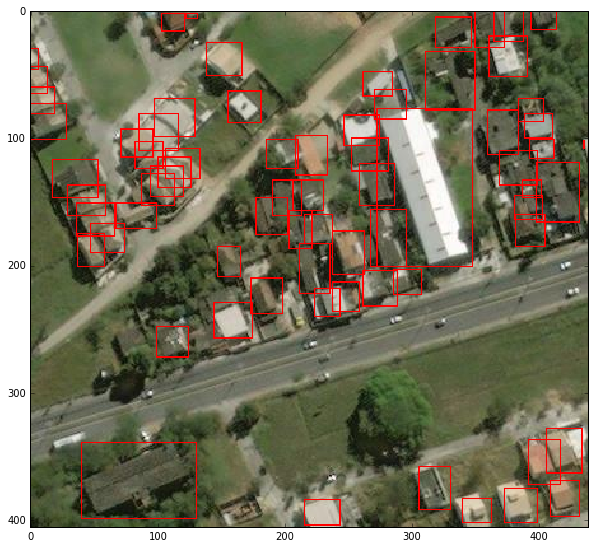

In [5]:
LABEL_FILE=open(LABELFILE).readlines()
testimage=Image.open(TESTIMAGE)
draw=ImageDraw.Draw(testimage)
for i in LABEL_FILE:
    a=np.array(i.split()[4:8],np.dtype(np.float))
    t=[float(x) for x in a]
    draw.rectangle(t,outline='red') #draw rectangles

plt.imshow(np.array(testimage))
testimage.save('input_target_overlay_'+TESTIMAGE[TESTIMAGE.rfind('/')+1:-4]+'.png')
print 'The number of bounding boxes is', len(LABEL_FILE)


In [6]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 1280, 1280)),
 ('transformed_data', (1, 3, 1280, 1280)),
 ('conv1/7x7_s2', (1, 64, 640, 640)),
 ('pool1/3x3_s2', (1, 64, 320, 320)),
 ('pool1/norm1', (1, 64, 320, 320)),
 ('conv2/3x3_reduce', (1, 64, 320, 320)),
 ('conv2/3x3', (1, 192, 320, 320)),
 ('conv2/norm2', (1, 192, 320, 320)),
 ('pool2/3x3_s2', (1, 192, 160, 160)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_0', (1, 192, 160, 160)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_1', (1, 192, 160, 160)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_2', (1, 192, 160, 160)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_3', (1, 192, 160, 160)),
 ('inception_3a/1x1', (1, 64, 160, 160)),
 ('inception_3a/3x3_reduce', (1, 96, 160, 160)),
 ('inception_3a/3x3', (1, 128, 160, 160)),
 ('inception_3a/5x5_reduce', (1, 16, 160, 160)),
 ('inception_3a/5x5', (1, 32, 160, 160)),
 ('inception_3a/pool', (1, 192, 160, 160)),
 ('inception_3a/pool_proj', (1, 32, 160, 160)),
 ('inception_3a/output', (1, 256, 160, 160)),
 ('inception_3a/output_inception_3a/output_0_sp

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [7]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1/7x7_s2', (64, 3, 7, 7)),
 ('conv2/3x3_reduce', (64, 64, 1, 1)),
 ('conv2/3x3', (192, 64, 3, 3)),
 ('inception_3a/1x1', (64, 192, 1, 1)),
 ('inception_3a/3x3_reduce', (96, 192, 1, 1)),
 ('inception_3a/3x3', (128, 96, 3, 3)),
 ('inception_3a/5x5_reduce', (16, 192, 1, 1)),
 ('inception_3a/5x5', (32, 16, 5, 5)),
 ('inception_3a/pool_proj', (32, 192, 1, 1)),
 ('inception_3b/1x1', (128, 256, 1, 1)),
 ('inception_3b/3x3_reduce', (128, 256, 1, 1)),
 ('inception_3b/3x3', (192, 128, 3, 3)),
 ('inception_3b/5x5_reduce', (32, 256, 1, 1)),
 ('inception_3b/5x5', (96, 32, 5, 5)),
 ('inception_3b/pool_proj', (64, 256, 1, 1)),
 ('inception_4a/1x1', (192, 480, 1, 1)),
 ('inception_4a/3x3_reduce', (96, 480, 1, 1)),
 ('inception_4a/3x3', (208, 96, 3, 3)),
 ('inception_4a/5x5_reduce', (16, 480, 1, 1)),
 ('inception_4a/5x5', (48, 16, 5, 5)),
 ('inception_4a/pool_proj', (64, 480, 1, 1)),
 ('inception_4b/1x1', (160, 512, 1, 1)),
 ('inception_4b/3x3_reduce', (112, 512, 1, 1)),
 ('inception_4b/3x3', (2

(80, 80)


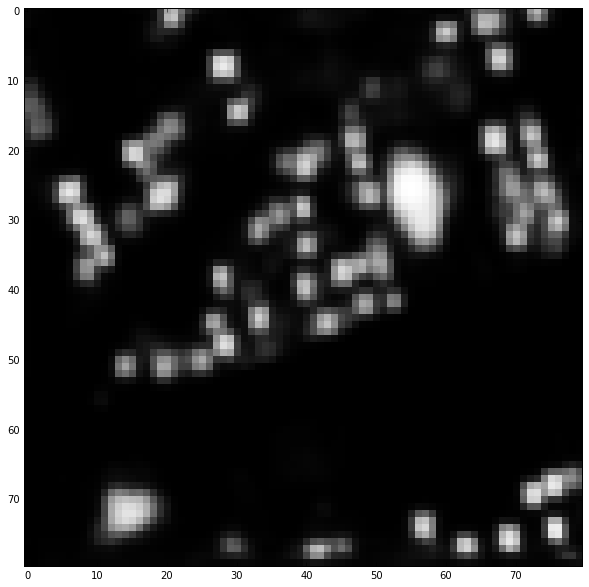

In [8]:
feat = net.blobs['coverage'].data[0][0]
print feat.shape
plt.imshow(feat)

plt.savefig('coverage_featuremap_'+TESTIMAGE[TESTIMAGE.rfind('/')+1:-4]+'.png')

Display the classifier layer `cvg/classifier`

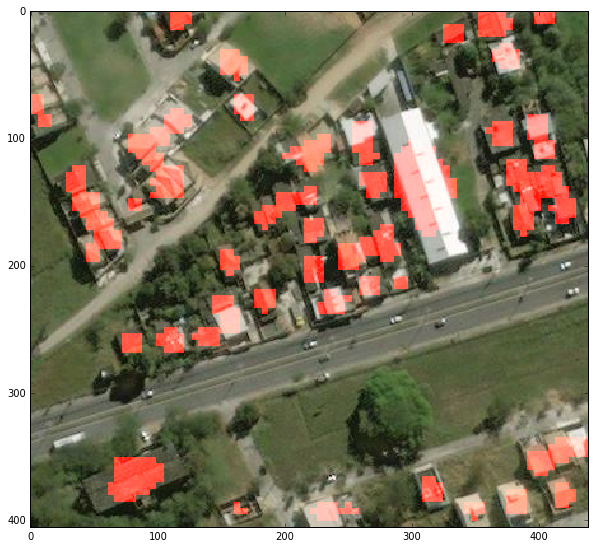

In [11]:
image = np.array(Image.open(TESTIMAGE)).astype('float32')
row,col,band=image.shape
data = transformer.preprocess('data', image)

#tmpImg = net.blobs['cvg/classifier'].data[0][0]
tmpImg = net.blobs['coverage'].data[0][0]
tmpImg += tmpImg.min()
tmpImg /= tmpImg.max()
tmpImg *= 255.
M=tmpImg.mean()
S=tmpImg.std()
new=np.array(Image.fromarray(tmpImg).resize((col,row)))
tmpImg=new

#image[tmpImg <M-S,0] = 245
image[tmpImg > np.min(tmpImg)+1.5*np.std(tmpImg),0] = 255
image = Image.fromarray(image.astype(np.uint8))
plt.imshow(np.array(image))
#That thresholds the network output "tmpImg" at 128 and colors the pixels accordingly in the raw image "image"
image.save('coverage_'+TESTIMAGE[TESTIMAGE.rfind('/')+1:-4]+'.png')

The number of ground truthbounding boxes is 70
The number of predicted bounding boxes plotted is 45
Some predicted boxes may overlap


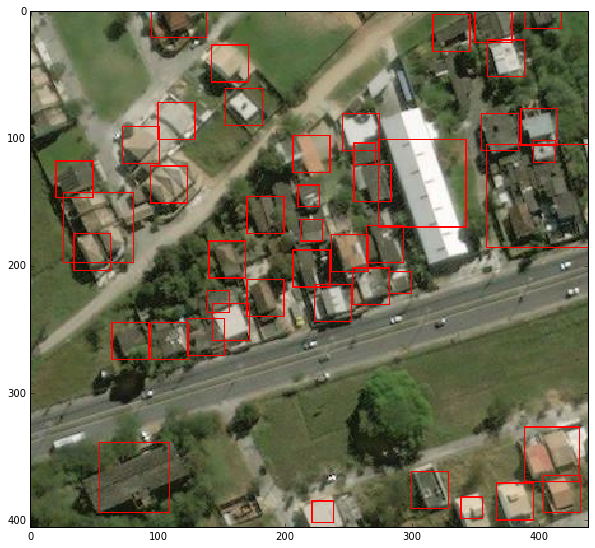

In [44]:
#While troubleshooting, I often experimented with Laplace of Gaussian function in skimage. 
tmpImg = net.blobs['coverage'].data[0][0]
tmpImg += tmpImg.min()
tmpImg /= tmpImg.max()
tmpImg *= 255.
M=tmpImg.mean()
S=tmpImg.std()
new=np.array(Image.fromarray(tmpImg).resize((col,row)))

#Adjust sigma and threshold to change the number of predicted buildings.
blobs_log = blob_log(new/255.,max_sigma=30, num_sigma=10, threshold=.2)

coverageimage=Image.open(TESTIMAGE)
draw=ImageDraw.Draw(coverageimage)
#out=net.forward()
total_boxes=[]
BuildingCoordinates=[]
for i in range(len(blobs_log)):
    square_box=blobs_log[i]
    if square_box[2]>2:#if sigma is less than 2 do not plot
        total_boxes+=[1]
        a=[square_box[1]-2.*square_box[2],square_box[0]-2.*square_box[2],
           square_box[1]+2.*square_box[2],square_box[0]+2.*square_box[2]]
        BuildingCoordinates.append(a)
        draw.rectangle(a,outline='red')

        
print 'The number of ground truthbounding boxes is', len(LABEL_FILE)
print 'The number of predicted bounding boxes plotted is',len(total_boxes) 
print 'Some predicted boxes may overlap'
plt.imshow(np.array(coverageimage))  
coverageimage.save('coverage_overlay_thresh3'+TESTIMAGE[TESTIMAGE.rfind('/')+1:-4]+'.png')

In [40]:
print blobs_log

[[   0.          117.           10.66666667]
 [   0.          403.            7.44444444]
 [  11.          364.            7.44444444]
 [  18.          331.            7.44444444]
 [  38.          374.            7.44444444]
 [  42.          157.            7.44444444]
 [  76.          168.            7.44444444]
 [  92.          400.            7.44444444]
 [  96.          260.            7.44444444]
 [  96.          369.            7.44444444]
 [ 106.           87.            7.44444444]
 [ 111.          404.            4.22222222]
 [ 113.          221.            7.44444444]
 [ 133.           35.            7.44444444]
 [ 136.          308.           17.11111111]
 [ 137.          109.            7.44444444]
 [ 146.          219.            4.22222222]
 [ 155.           47.            7.44444444]
 [ 166.          387.            7.44444444]
 [ 173.          221.            4.22222222]
 [ 191.          251.            7.44444444]
 [ 196.          155.            7.44444444]
 [ 203.   

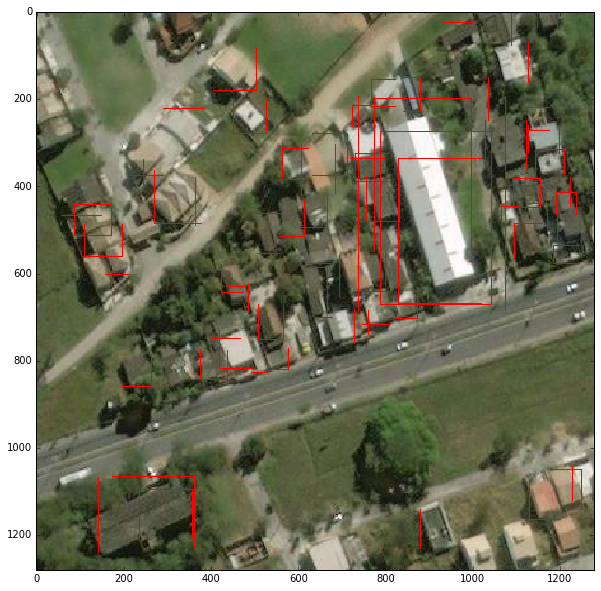

In [11]:
coverageimage=Image.open(TESTIMAGE).resize((1280,1280))

draw=ImageDraw.Draw(coverageimage)

grow=net.blobs['bbox-list'].data[0]

for i in range(75):
    draw.rectangle(grow[i][:4].tolist(),outline=((255,0,0)))
   
plt.imshow(np.array(coverageimage)) 
